## Multiscale latents 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


### Checking old tasks for optim dynamcis

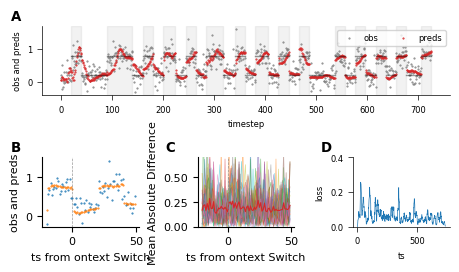

In [5]:
# Initiate and maybe Train RNN 
train_model = True
horizon_long_short = 'short'
# horizon_long_short = 'long'
scale = 10
experiment = 1
config = Config()
config.default_std = default_std
training_phase_1_config = {'context_transition_function': 'geometric', #'fixed_random_sequences',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':30}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = True
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )



/tmp/ipykernel_1328669/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


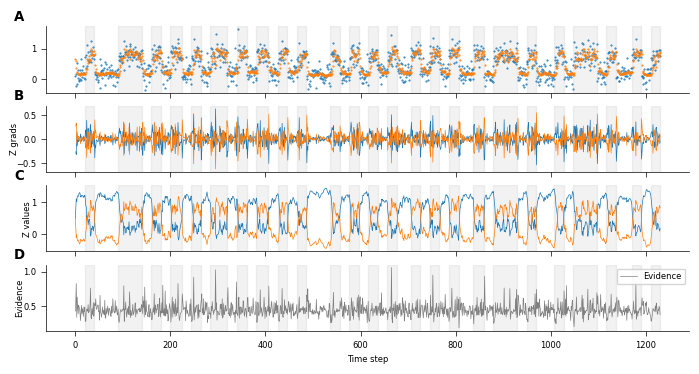

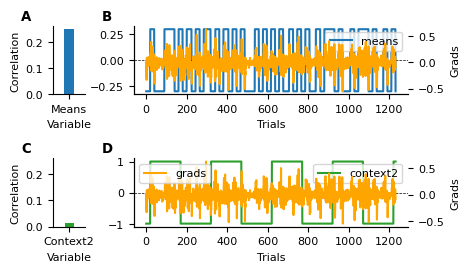

In [6]:
# Get thalamus initial inference values
horizon_long_short = 'short'
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
# optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
optimizer = 'LU'
logger = Logger(config)
config.momentum = 0.1
config.LU_lr = 1
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = True
config.backprop_only_last_timestep = False
testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

# Back to experiment 7 and 8

# Experiment 9!

In [7]:
# Initiate and maybe Train RNN 
train_model = False
horizon_long_short = 'short'
# horizon_long_short = 'long'
scale = 3
experiment = 8
config = Config()
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

/tmp/ipykernel_1328669/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


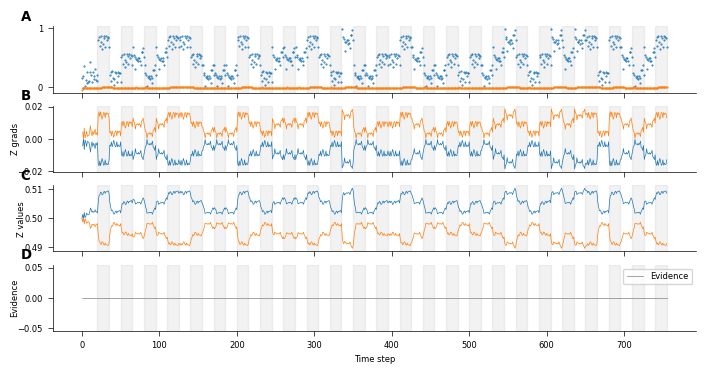

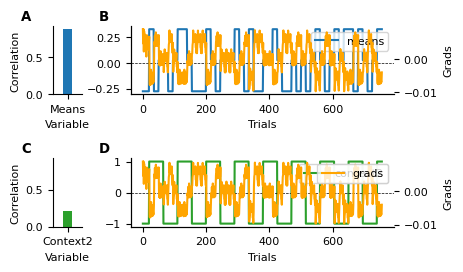

In [8]:
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = False

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus_last_only = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

/tmp/ipykernel_1328669/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


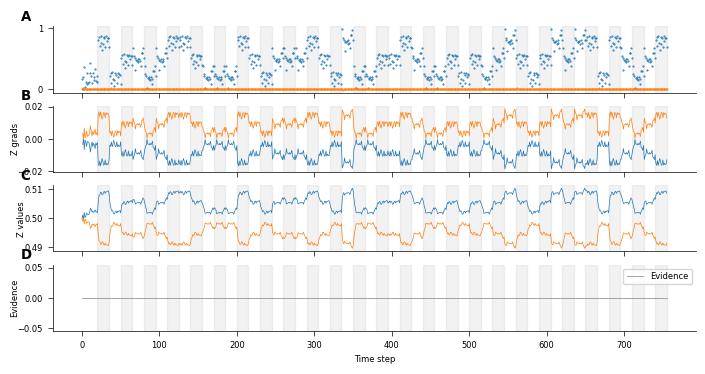

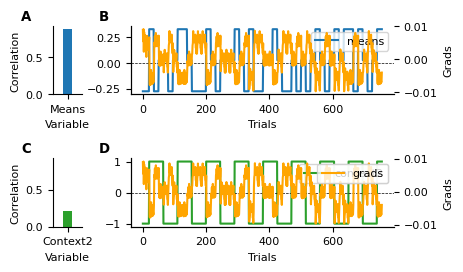

In [9]:
# Get thalamus initial inference values
# horizon_long_short = 'long'
# horizon_long_short = 'short'
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = False

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus_last_only = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

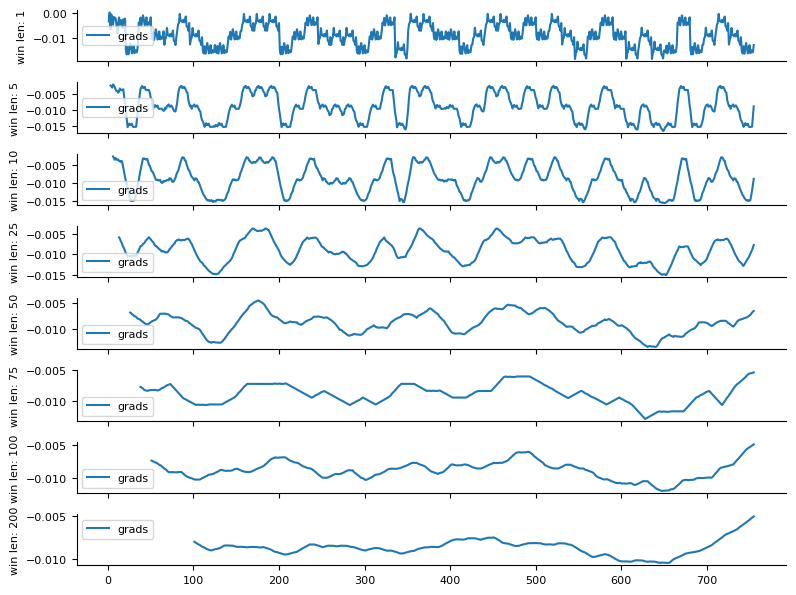

In [10]:
pre_training_grads = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
pre_training_grads = pre_training_grads.squeeze()[:, 0] # take only one unit grads

# filter the pre_training_grads with multiple filters of lengths 5, 10, 20, 50, 100, 200, 500, 1000 and plot them
filters = [1, 5, 10, 25, 50, 75, 100, 200, ]
fig, axes = plt.subplots(len(filters),1, figsize=(8,6), sharex=True, )
axes_iterator = iter(axes)
for filter in filters:
    ax = next(axes_iterator)
    ax.plot(np.convolve(pre_training_grads, np.ones(filter)/filter, mode='same'), label='grads')
    ax.set_ylabel(f'win len: {filter}')
    # ax.set_xlabel('Trials')
    ax.legend()
    fig.tight_layout()

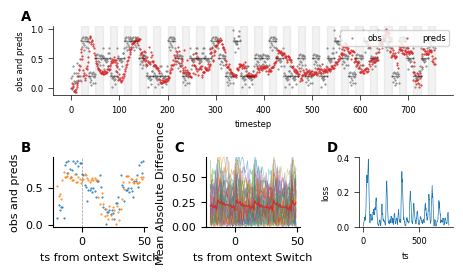

In [11]:
# now train again with the thalamus values prespecified
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
WU_optimizer = 'WU'
ts_in_training= 0
if horizon == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger,
        # prespecified_thalamus=prespecified_thalamus, input_distort=True)
        prespecified_thalamus=(prespecified_thalamus-0.5 )*10, input_distort=True)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)


# Putting it all together

/tmp/ipykernel_1328669/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


TypeError: get_correlations() got an unexpected keyword argument 'use_thalamus'

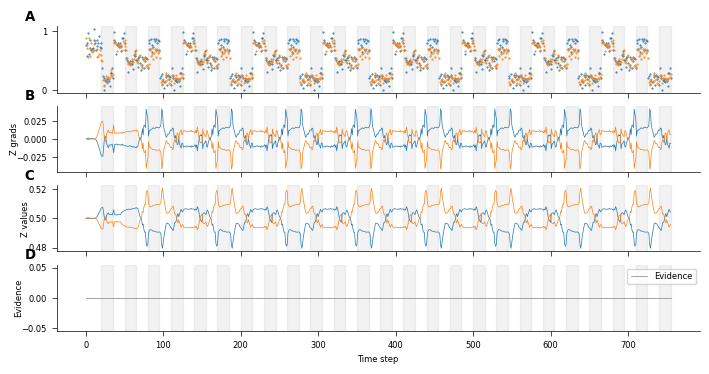

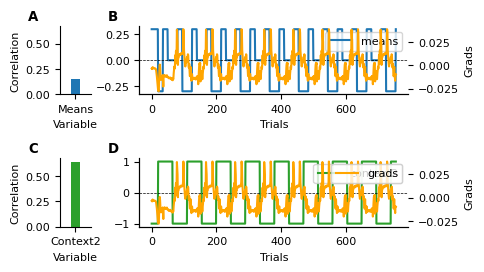

In [12]:
# Initiate RNN and config 
loss_means = []
corr_Thalamus_context2s = []
corr_Thalamus_meanss = []
prespecified_thalamus_values = []

plot_plots = True
save_plots = False
use_prespecified_thalamus = True
no_of_blocks = 50
pretrain_model = True
# horizon_long_short = 'short'
horizon_long_short = 'long'
input_distort=False
scale = 3
experiment = 9
config = Config()
config.accummulate_thalamus_temporally = True
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (3)) # note this was 3 before when I was working on exp 9
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

if pretrain_model:
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        config.training_phases[0]['config']['no_of_blocks'] = 100
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)


for iteration in (range(3)):
        # print('running iteration: ', iteration)
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        # Get latent inference values
        config.training_phases[0]['config']['no_of_blocks'] = no_of_blocks
        config.seed_env = iteration # a different sequence of random means each block, but the same fixed random pattern inside the blocks
        testing_env = Generative_environment(config, experiment=experiment)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_optimized_thalamus = False
        config.accummulate_thalamus_temporally = True
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, 'LU', horizon, criterion,
                                                        0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
        if plot_plots: plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/grads_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/modulations_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        use_grads = False
        if use_grads:
                prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
                prespecified_thalamus[0] = 0 # first value is padded with a nan
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                stats(prespecified_thalamus)
        else:
                prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
                # These were already softmaxed. but I want to softmax them with a lower temperature
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                # prespecified_thalamus = F.softmax(torch.tensor(prespecified_thalamus), dim=0, ).numpy()

        corr_Thalamus_context2, corr_Thalamus_means = get_correlations(testing_memory_buffer, testing_env, config, use_thalamus=False)
        corr_Thalamus_context2s.append(corr_Thalamus_context2)
        corr_Thalamus_meanss.append(corr_Thalamus_means)
        # now train again with the thalamus values prespecified
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        if use_prespecified_thalamus:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
        else:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)
        loss_means.append(np.mean(losses))
        if plot_plots: plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

fig, axes = plt.subplots(1,2, figsize=(8,2))
ax = axes[0]
ax.plot(loss_means)
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
ax = axes[1]
ax.plot(corr_Thalamus_context2s, label='context2')
ax.plot(corr_Thalamus_meanss, label='means')
ax.set_ylabel('Correlation')
ax.set_xlabel('Iteration')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(9,3))
# plot each vector of thalamus values with viridis color gradations
for i in range(len(prespecified_thalamus_values)):
        ax.plot(prespecified_thalamus_values[i].squeeze()[:,0], color=plt.cm.viridis(i/len(prespecified_thalamus_values)), label=f'iter {i}')
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()


# Use the copy below to play with exp 8

/tmp/ipykernel_1287892/3963989761.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


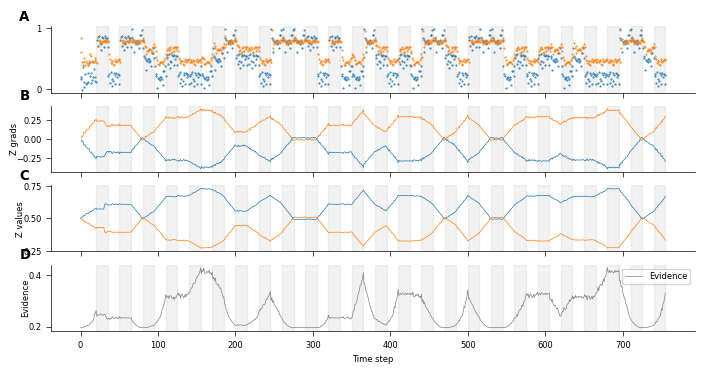

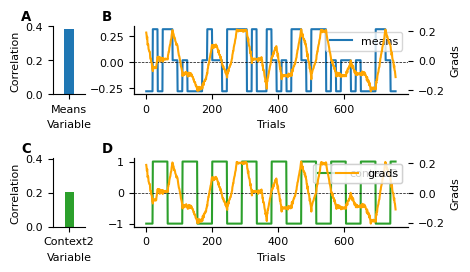

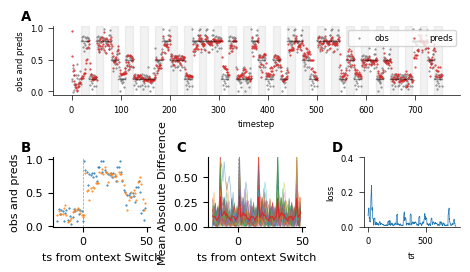

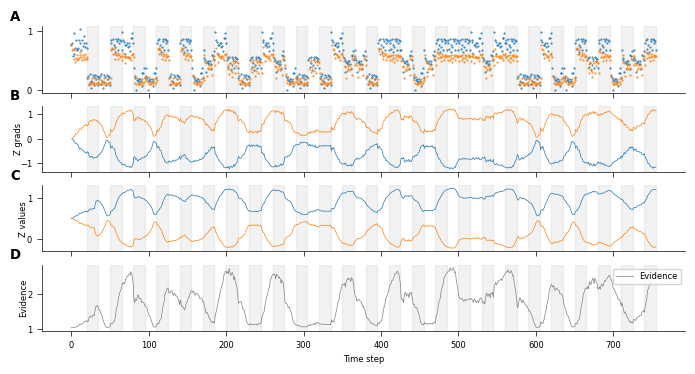

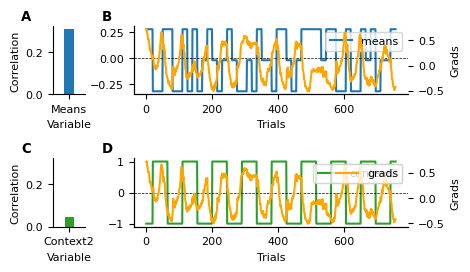

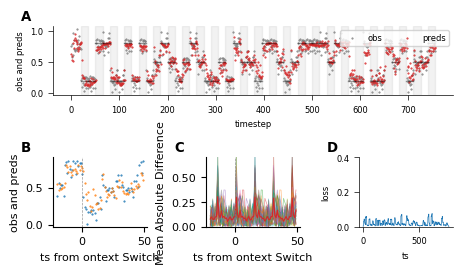

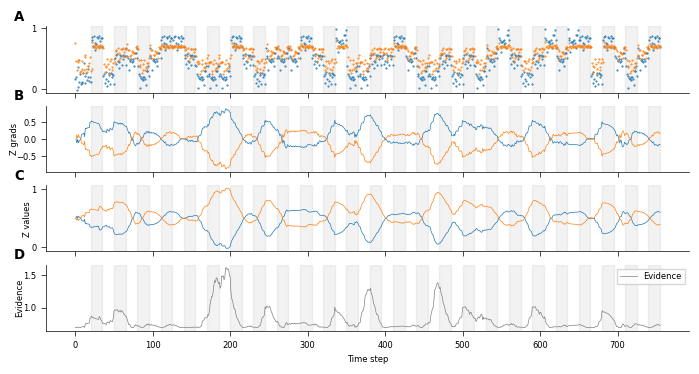

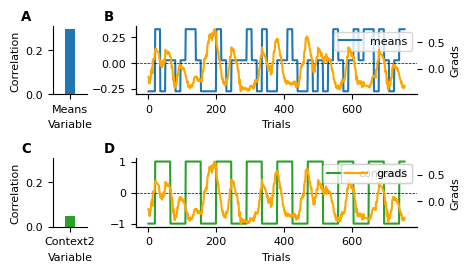

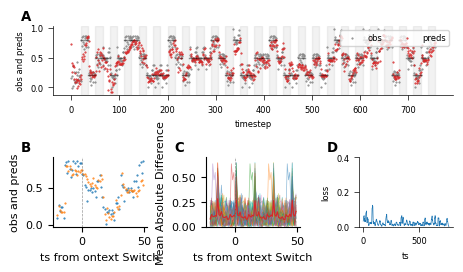

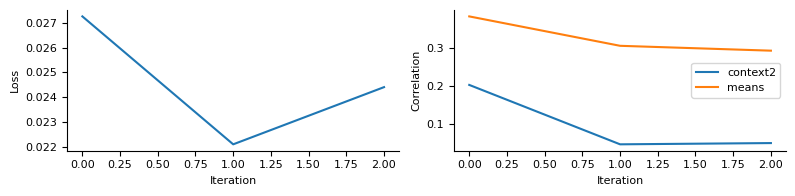

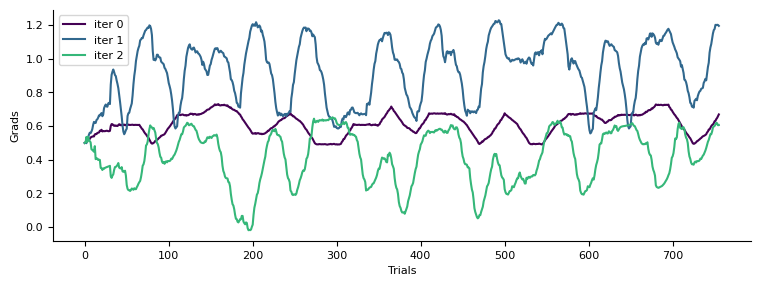

In [ ]:
# Initiate RNN and config 
loss_means = []
corr_Thalamus_context2s = []
corr_Thalamus_meanss = []
prespecified_thalamus_values = []

plot_plots = True
save_plots = False
use_prespecified_thalamus = True
no_of_blocks = 50
pretrain_model = True
# horizon_long_short = 'short'
horizon_long_short = 'long'
input_distort=False
scale = 3
experiment = 8
config = Config()
config.accummulate_thalamus_temporally = True
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (2)) # note this was 3 before when I was working on exp 9
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

if pretrain_model:
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        config.training_phases[0]['config']['no_of_blocks'] = 100
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)


for iteration in (range(3)):
        # print('running iteration: ', iteration)
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        # Get latent inference values
        config.training_phases[0]['config']['no_of_blocks'] = no_of_blocks
        config.seed_env = iteration # a different sequence of random means each block, but the same fixed random pattern inside the blocks
        testing_env = Generative_environment(config, experiment=experiment)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_optimized_thalamus = False
        config.accummulate_thalamus_temporally = True
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, 'LU', horizon, criterion,
                                                        0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
        if plot_plots: plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/grads_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/modulations_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        use_grads = False
        if use_grads:
                prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
                prespecified_thalamus[0] = 0 # first value is padded with a nan
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                stats(prespecified_thalamus)
        else:
                prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
                # These were already softmaxed. but I want to softmax them with a lower temperature
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                # prespecified_thalamus = F.softmax(torch.tensor(prespecified_thalamus), dim=0, ).numpy()

        corr_Thalamus_context2, corr_Thalamus_means = get_correlations(testing_memory_buffer, testing_env, config, use_thalamus=False)
        corr_Thalamus_context2s.append(corr_Thalamus_context2)
        corr_Thalamus_meanss.append(corr_Thalamus_means)
        # now train again with the thalamus values prespecified
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        if use_prespecified_thalamus:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
        else:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)
        loss_means.append(np.mean(losses))
        if plot_plots: plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

fig, axes = plt.subplots(1,2, figsize=(8,2))
ax = axes[0]
ax.plot(loss_means)
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
ax = axes[1]
ax.plot(corr_Thalamus_context2s, label='context2')
ax.plot(corr_Thalamus_meanss, label='means')
ax.set_ylabel('Correlation')
ax.set_xlabel('Iteration')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(9,3))
# plot each vector of thalamus values with viridis color gradations
for i in range(len(prespecified_thalamus_values)):
        ax.plot(prespecified_thalamus_values[i].squeeze()[:,0], color=plt.cm.viridis(i/len(prespecified_thalamus_values)), label=f'iter {i}')
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()


# Z1 Z2!

In [ ]:
# Initiate and maybe Train RNN 
train_model = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
scale = 3
experiment = 9
config = Config(context_units = 4) # increase thalamus units
config.no_of_latents = 2
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

/tmp/ipykernel_1325928/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


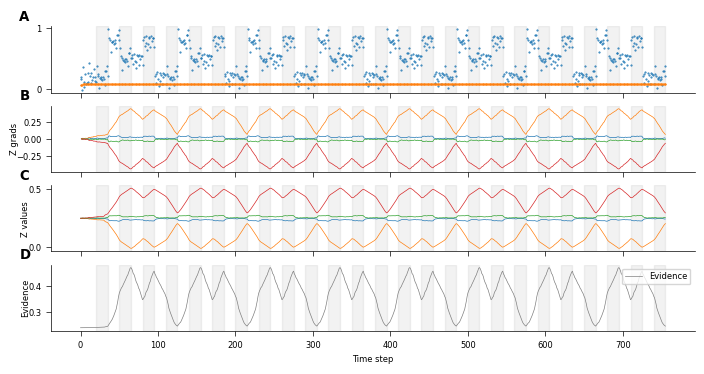

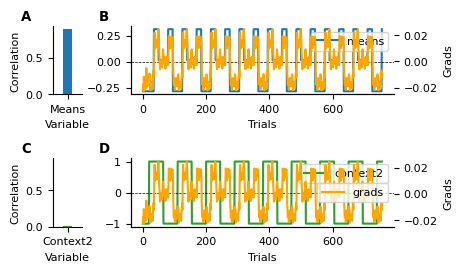

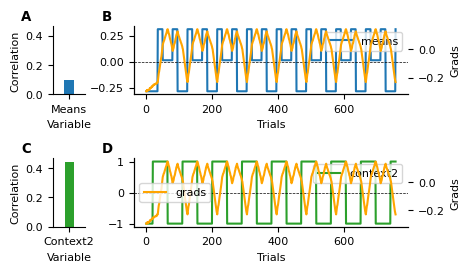

In [ ]:
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = True

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus_last_only = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)

/tmp/ipykernel_1325928/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


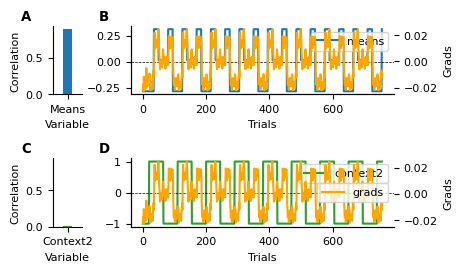

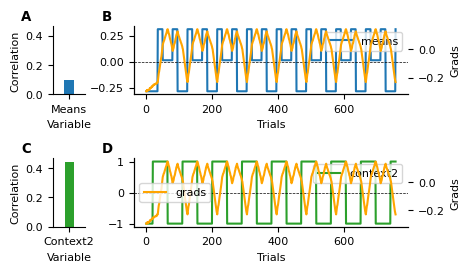

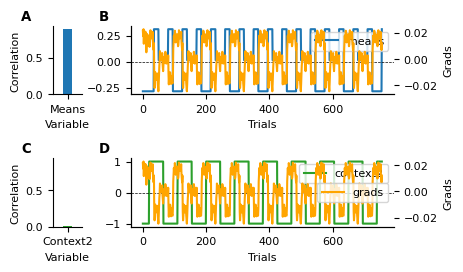

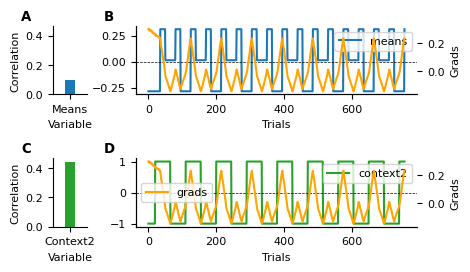

In [ ]:

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 2)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 3)

/tmp/ipykernel_1325928/699459920.py:58: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().join(ax, ax2)


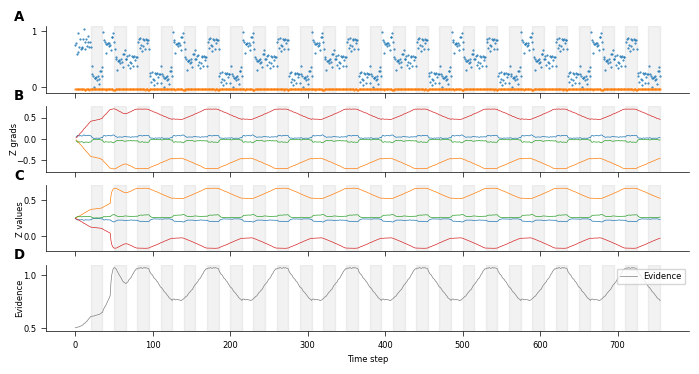

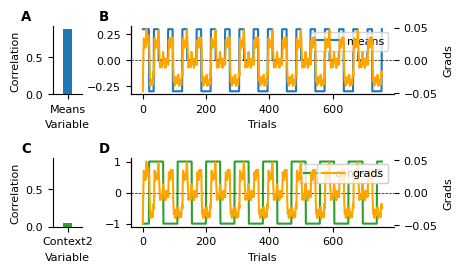

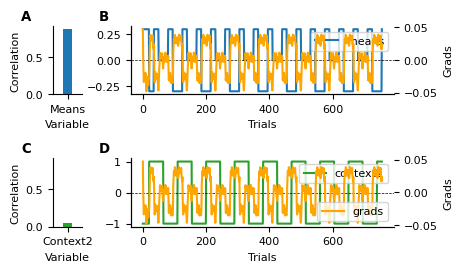

Mean, 0.00000, var 17.07840, min -7.072, max 7.072, norm 227.2554931640625


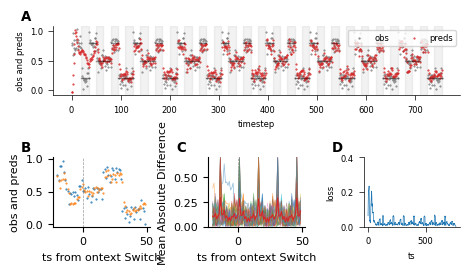

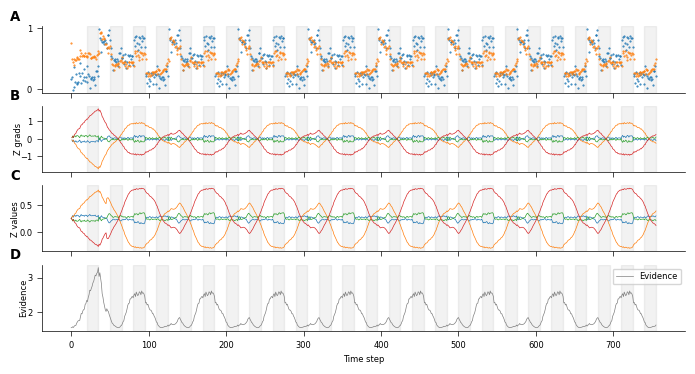

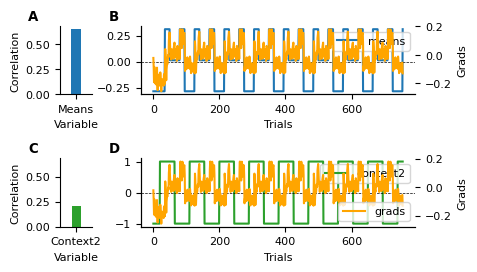

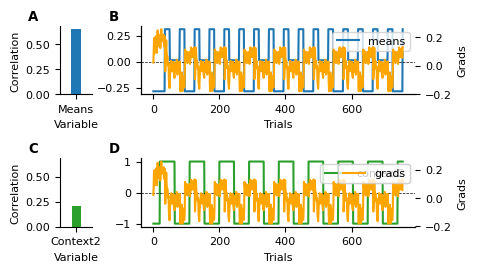

Mean, 0.00000, var 19.39682, min -17.298, max 17.298, norm 242.18997192382812


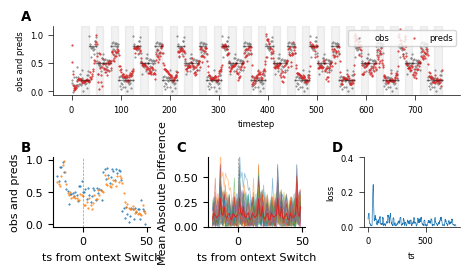

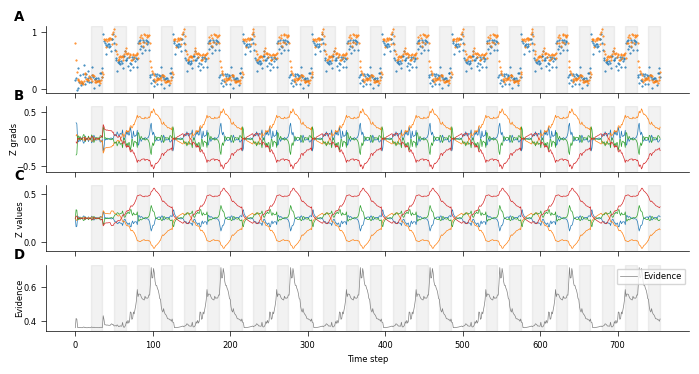

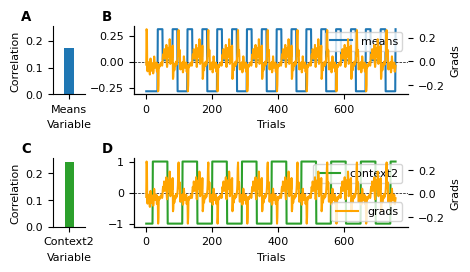

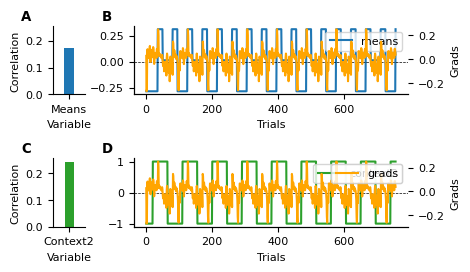

Mean, 0.00000, var 4.30129, min -5.574, max 5.574, norm 114.0486831665039


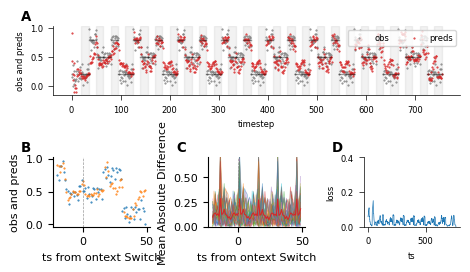

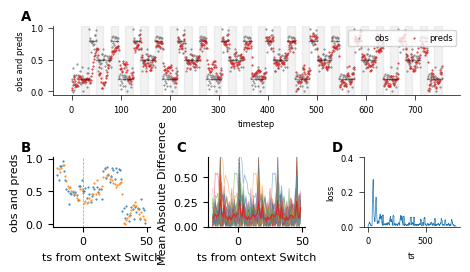

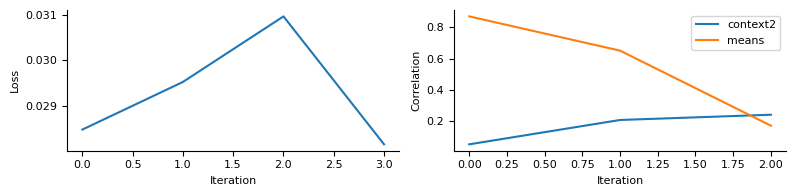

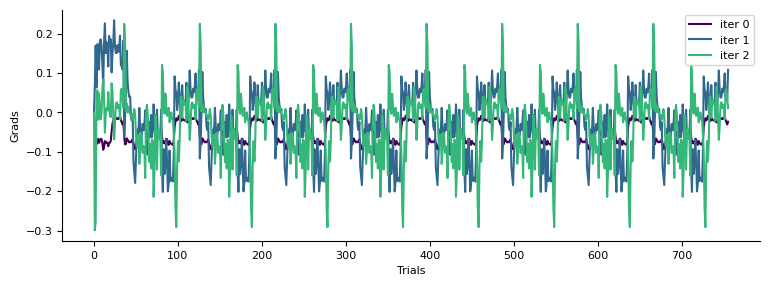

In [ ]:
# Initiate RNN and config 
loss_means = []
corr_Thalamus_context2s = []
corr_Thalamus_meanss = []
prespecified_thalamus_values = []

plot_plots = True
save_plots = False
use_prespecified_thalamus = True
no_of_blocks = 50
pretrain_model = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
input_distort=False
scale = 3
experiment = 9
config = Config(context_units=4)
config.no_of_latents = 2
config.accummulate_thalamus_temporally = True
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (3)) # note this was 3 before when I was working on exp 9
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

if pretrain_model:
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        config.training_phases[0]['config']['no_of_blocks'] = 100
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)


for iteration in (range(3)):
        # print('running iteration: ', iteration)
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        # Get latent inference values
        config.training_phases[0]['config']['no_of_blocks'] = no_of_blocks
        config.seed_env = iteration # a different sequence of random means each block, but the same fixed random pattern inside the blocks
        testing_env = Generative_environment(config, experiment=experiment)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_optimized_thalamus = False
        config.accummulate_thalamus_temporally = True
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, 'LU', horizon, criterion,
                                                        0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
        if plot_plots: plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/grads_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim =0)
        plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim =2)
        plt.show()
        plt.close('all')
        if save_plots and plot_plots: plt.savefig(f'./exports/modulations_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        use_grads = True
        if use_grads:
                prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
                prespecified_thalamus[0] = 0 # first value is padded with a nan
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                stats(prespecified_thalamus)
        else:
                prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
                # These were already softmaxed. but I want to softmax them with a lower temperature
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                # prespecified_thalamus = F.softmax(torch.tensor(prespecified_thalamus), dim=0, ).numpy()

        corr_Thalamus_context2, corr_Thalamus_means = get_correlations(testing_memory_buffer, testing_env, config, use_grads=use_grads)
        corr_Thalamus_context2s.append(corr_Thalamus_context2)
        corr_Thalamus_meanss.append(corr_Thalamus_means)
        # now train again with the thalamus values prespecified
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        if use_prespecified_thalamus:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
        else:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)
        loss_means.append(np.mean(losses))
        if plot_plots: plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

### NEW MODEL
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
if use_prespecified_thalamus:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
else:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=None, input_distort=input_distort)
loss_means.append(np.mean(losses))
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

fig, axes = plt.subplots(1,2, figsize=(8,2))
ax = axes[0]
ax.plot(loss_means)
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
ax = axes[1]
ax.plot(corr_Thalamus_context2s, label='context2')
ax.plot(corr_Thalamus_meanss, label='means')
ax.set_ylabel('Correlation')
ax.set_xlabel('Iteration')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(9,3))
# plot each vector of thalamus values with viridis color gradations
for i in range(len(prespecified_thalamus_values)):
        ax.plot(prespecified_thalamus_values[i].squeeze()[:,0], color=plt.cm.viridis(i/len(prespecified_thalamus_values)), label=f'iter {i}')
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()


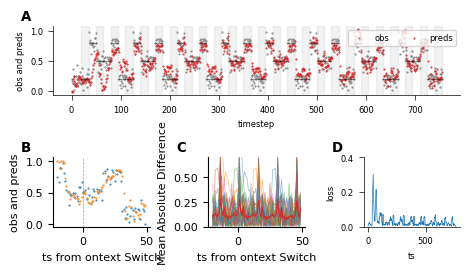

In [ ]:
### NEW MODEL
use_prespecified_thalamus = True
horizon = 5
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
if use_prespecified_thalamus:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
else:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=None, input_distort=input_distort)
loss_means.append(np.mean(losses))
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)


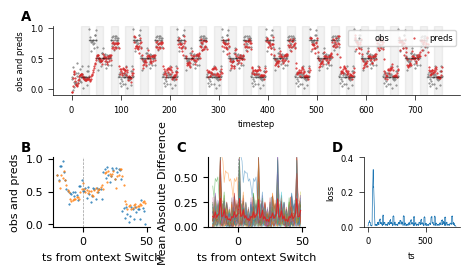

: 

In [ ]:
### NEW MODEL
use_prespecified_thalamus = False
horizon = 5
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
if use_prespecified_thalamus:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
else:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=None, input_distort=input_distort)
loss_means.append(np.mean(losses))
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)


In [ ]:
prespecified_thalamus.shape

(756, 1, 1, 4)

In [ ]:
# Now train a fresh new model with the prescpecified thalamus from last iteration
horizon_long_short = 'long'
input_distort=False
scale = 3
experiment = 9
config = Config(context_units=4)
config.no_of_latents = 2
config.accummulate_thalamus_temporally = True
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (3)) # note this was 3 before when I was working on exp 9
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
config.training_phases[0]['config']['no_of_blocks'] = 100
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)


input.shape torch.Size([45, 1, 1])
self.thalamus.shape torch.Size([44, 1, 4])


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 45 but got size 44 for tensor number 1 in the list.